In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import gym.spaces
from matplotlib import pyplot as plt
%matplotlib inline

In [105]:
# Create Neural Net
# https://pytorch.org/docs/master/nn.html
class NN(nn.Module):
    def __init__(self, hidden_layer, n_s, n_a):
        super(NN, self).__init__()
        self.l1 = nn.Linear(n_s, hidden_layer)
        #self.l1.weight.data.fill_(0)
        self.l2 = nn.Linear(hidden_layer, n_a)
        #self.l2.weight.data.fill_(0)
        
    def forward(self,x):
        x = F.relu(self.l1(x))
        return F.relu(self.l2(x))        

In [133]:
# Create DQN
class DQN:
    def __init__(self, alpha, alpha_decay, final_alpha, 
                 gamma, epsilon, epsilon_decay, 
                 final_epsilon, memory_cap, nn_update_iter, 
                 n_a, n_s, hidden_layer, batch_size):
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.final_alpha = final_alpha
        self.gamma = gamma
        self.cur_e = epsilon
        self.e_decay = epsilon_decay
        self.final_e = final_epsilon
        self.memory_cap = memory_cap
        self.memory = np.zeros((memory_cap, 2 * n_s + 2))
        self.nn_update_iter = nn_update_iter
        self.n_a = n_a
        self.n_s = n_s
        self.hidden_layer = hidden_layer
        self.train_nn = NN(self.hidden_layer, self.n_s, self.n_a)
        self.final_nn = NN(self.hidden_layer, self.n_s, self.n_a)
        self.memory_pointer = 0
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(self.train_nn.parameters(), lr=alpha)
        
    def select_train_action(self, s):
        #print s
        s = torch.unsqueeze(torch.FloatTensor(s), 0)
        #print s
        if np.random.random() > self.cur_e:
            a_value = self.train_nn.forward(s)
            #print a_value
            action = torch.max(a_value, 1)[1].numpy()
            action = action[0]
            #print action
        else:
            action = env.action_space.sample()        
        return action
    
    def select_test_action(self,s):
        
        return action
    
    def save_history(self, s, a, r, next_s):
        self.memory[self.memory_pointer,:] = np.hstack((s, a, r, next_s))
        if self.memory_pointer != self.memory_cap-1:
            self.memory_pointer = self.memory_pointer + 1
        else:
            self.memory_pointer = 0
            
    def update_param(self):
        torch.save(self.train_nn.state_dict(), 'params.pkl')
        self.final_nn.load_state_dict(torch.load('params.pkl'))
                
    def learn(self):
        batch = self.memory[np.random.choice(self.memory_cap, self.batch_size), :]
        batch_s = torch.FloatTensor(batch[:, :self.n_s])
        batch_a = torch.LongTensor(batch[:, self.n_s:self.n_s+1])
        batch_r = torch.FloatTensor(batch[:, self.n_s+1:self.n_s+2])
        batch_next_s = torch.FloatTensor(batch[:, self.n_s+2:])
        
        cur_q = self.train_nn(batch_s).gather(1, batch_a)
        #print cur_q
        next_q = self.final_nn(batch_next_s).detach()
        expected_q = batch_r + self.gamma * next_q.max(1)[0].view(self.batch_size, 1)
        
        loss = F.smooth_l1_loss(cur_q, expected_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.alpha > self.final_alpha: self.alpha = self.alpha - self.alpha_decay
        if self.cur_e > self.final_e: self.cur_e = self.cur_e - self.e_decay
        
        
        

    

In [144]:
env = gym.make('LunarLander-v2')
agent = DQN(alpha = 0.001, alpha_decay = 0, 
            final_alpha = 0.001, gamma = 0.99, 
            epsilon = 1, epsilon_decay = 0.00005, 
            final_epsilon = 0.01, memory_cap = 100000, 
            nn_update_iter = 1500, 
            n_a = env.action_space.n, 
            n_s = env.observation_space.shape[0], 
            hidden_layer = 100, batch_size = 32)

reward_list = []
running_r = 0
running_r_list = []
total_step = 0
#test_break = 0

for episode in range(5000):
    if episode%100 == 0: print('Ep: ', episode, '| Running_r: ', round(running_r, 1), 
                               '| total_step: ', round(total_step, 0), 
                               '| epsilon: ', round(agent.cur_e, 5),
                               '| alpha: ', round(agent.alpha, 5))
    total_reward = 0
    s = env.reset()
    done = 0
    while done == 0:
        # choose an action based on current state
        a = agent.select_train_action(s)
        # proceed with above action
        next_s, r, done, info = env.step(a)
        total_reward = total_reward + r
        agent.save_history(s, a, r, next_s)

        if total_step > agent.memory_cap:
            #print('I am inside the learning loop')
            #print agent.memory
            #test_break = 1
            #break
            if total_step%agent.nn_update_iter:
                agent.update_param()
            agent.learn()

        if done:
            reward_list.append(total_reward)
            if len(reward_list) > 100: 
                running_r = sum(reward_list[len(reward_list) - 100:])/100
                running_r_list.append(running_r)

        s = next_s
        total_step = total_step + 1
    #if test_break == 1: break
print("process complete")




WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
('Ep: ', 0, '| Running_r: ', 0.0, '| total_step: ', 0.0, '| epsilon: ', 1.0, '| alpha: ', 0.001)
('Ep: ', 100, '| Running_r: ', 0.0, '| total_step: ', 9264.0, '| epsilon: ', 1.0, '| alpha: ', 0.001)
('Ep: ', 200, '| Running_r: ', -231.1, '| total_step: ', 18400.0, '| epsilon: ', 1.0, '| alpha: ', 0.001)
('Ep: ', 300, '| Running_r: ', -241.9, '| total_step: ', 27730.0, '| epsilon: ', 1.0, '| alpha: ', 0.001)
('Ep: ', 400, '| Running_r: ', -226.4, '| total_step: ', 36844.0, '| epsilon: ', 1.0, '| alpha: ', 0.001)
('Ep: ', 500, '| Running_r: ', -230.8, '| total_step: ', 45864.0, '| epsilon: ', 1.0, '| alpha: ', 0.001)
('Ep: ', 600, '| Running_r: ', -237.0, '| total_step: ', 55292.0, '| epsilon: ', 1.0, '| alpha: ', 0.001)
('Ep: ', 700, '| Running_r: ', -217.6, '| total_step: ', 64470.0, '| epsilon: ', 1.0, '| alpha: ', 0.001)
('Ep: ', 800, '| Running_r: ', -230.5, '| total_step: ', 73485.0, '

In [145]:
for episode in range(5000):
    if episode%100 == 0: print('Ep: ', episode, '| Running_r: ', round(running_r, 1), 
                               '| total_step: ', round(total_step, 0), 
                               '| epsilon: ', round(agent.cur_e, 5),
                               '| alpha: ', round(agent.alpha, 5))
    total_reward = 0
    s = env.reset()
    done = 0
    while done == 0:
        # choose an action based on current state
        a = agent.select_train_action(s)
        # proceed with above action
        next_s, r, done, info = env.step(a)
        total_reward = total_reward + r
        agent.save_history(s, a, r, next_s)

        if total_step > agent.memory_cap:
            #print('I am inside the learning loop')
            #print agent.memory
            #test_break = 1
            #break
            if total_step%agent.nn_update_iter:
                agent.update_param()
            agent.learn()

        if done:
            reward_list.append(total_reward)
            if len(reward_list) > 100: 
                running_r = sum(reward_list[len(reward_list) - 100:])/100
                running_r_list.append(running_r)

        s = next_s
        total_step = total_step + 1
    #if test_break == 1: break
print("process complete")

('Ep: ', 0, '| Running_r: ', 157.4, '| total_step: ', 1858346.0, '| epsilon: ', 0.00995, '| alpha: ', 0.001)
('Ep: ', 100, '| Running_r: ', 165.8, '| total_step: ', 1899242.0, '| epsilon: ', 0.00995, '| alpha: ', 0.001)
('Ep: ', 200, '| Running_r: ', 71.7, '| total_step: ', 1924690.0, '| epsilon: ', 0.00995, '| alpha: ', 0.001)
('Ep: ', 300, '| Running_r: ', 82.3, '| total_step: ', 1965662.0, '| epsilon: ', 0.00995, '| alpha: ', 0.001)
('Ep: ', 400, '| Running_r: ', 153.4, '| total_step: ', 2011453.0, '| epsilon: ', 0.00995, '| alpha: ', 0.001)
('Ep: ', 500, '| Running_r: ', 145.9, '| total_step: ', 2053111.0, '| epsilon: ', 0.00995, '| alpha: ', 0.001)
('Ep: ', 600, '| Running_r: ', 166.4, '| total_step: ', 2097485.0, '| epsilon: ', 0.00995, '| alpha: ', 0.001)
('Ep: ', 700, '| Running_r: ', 187.3, '| total_step: ', 2140280.0, '| epsilon: ', 0.00995, '| alpha: ', 0.001)
('Ep: ', 800, '| Running_r: ', 136.0, '| total_step: ', 2178579.0, '| epsilon: ', 0.00995, '| alpha: ', 0.001)
('Ep:

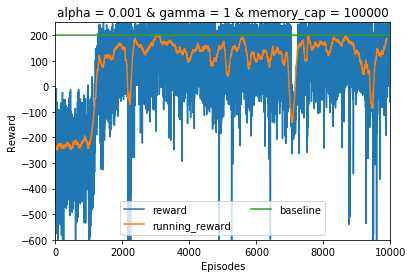

In [152]:
baseline = []
for i in range (1,10000): baseline.append(200)
plt.plot(reward_list)
plt.plot(running_r_list)
plt.plot(baseline)
plt.axis([0, 10000, -600, 250])
plt.title("alpha = 0.001 & gamma = 1 & memory_cap = 100000")
plt.xlabel("Episodes")
plt.ylabel("Reward")
label = ["reward", "running_reward", "baseline"]
plt.legend(label, loc = 0, ncol = 2)